## Imports

In [51]:
import pandas as pd
import numpy as np
import datetime
import time
import os

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting (Optional)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Config

In [17]:
# --- Configuration ---
WEATHER_DATA_PATH = "synthetic_weather_data.csv"
OPERATIONS_DATA_PATH = "synthetic_operations_log.csv"
# !!! IMPORTANT: Set this to the actual start date used for weather generation !!!
SIMULATION_START_DATE = '2023-01-01'

# --- Feature Engineering Parameters ---
FORECAST_HORIZON_HOURS = 48 # How many hours of weather forecast to use as features
TIME_WINDOWS = [6, 12, 24, 48] # Summary windows for weather features (in hours)
TARGET_COLUMN = 'total_weather_delay_hrs'

In [18]:
# --- Load Data ---
print("Loading data...")
try:
    weather_df = pd.read_csv(WEATHER_DATA_PATH, index_col=0, parse_dates=True)
    ops_df = pd.read_csv(OPERATIONS_DATA_PATH)
    print(f"Loaded {len(weather_df)} weather records and {len(ops_df)} operations records.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the CSV files exist at the specified paths.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()

Loading data...
Loaded 2137 weather records and 1453 operations records.


## Feature Engineering

In [19]:
# --- Feature Engineering ---
print("Performing feature engineering...")
base_datetime = pd.to_datetime(SIMULATION_START_DATE)

# 1. Convert arrival_time (hours) to actual timestamp
ops_df['arrival_timestamp'] = ops_df['arrival_time'].apply(lambda h: base_datetime + pd.Timedelta(hours=h))

# 2. Add basic time features from arrival_timestamp
ops_df['arrival_hour'] = ops_df['arrival_timestamp'].dt.hour
ops_df['arrival_dayofweek'] = ops_df['arrival_timestamp'].dt.dayofweek
ops_df['arrival_month'] = ops_df['arrival_timestamp'].dt.month


Performing feature engineering...


In [20]:
# 3. Function to extract future weather features for a given arrival time
def get_weather_features(arrival_ts, weather_data, horizon_h, windows):
    """
    Extracts summary statistics of weather variables over future time windows.
    """
    forecast_start_time = arrival_ts
    forecast_end_time = forecast_start_time + pd.Timedelta(hours=horizon_h)

    # Select the relevant forecast period from weather data
    # Ensure index is sorted for efficient lookup
    if not weather_data.index.is_monotonic_increasing:
         weather_data = weather_data.sort_index()

    # Use slicing which is efficient on DatetimeIndex
    forecast_data = weather_data.loc[forecast_start_time : forecast_end_time]

    if forecast_data.empty:
        # Handle cases where arrival is too late for the forecast horizon
        # Return NaNs or default values - NaNs are better to see issues
        cols = [f'{var}_{agg}_{w}h'
                for w in windows
                for var in ['wind_speed_knots', 'visibility_nm', 'wave_height_m'] # Add other relevant vars
                for agg in ['mean', 'max', 'min', 'std']]
        return pd.Series(index=cols, dtype=np.float64)

    features = {}
    weather_vars_to_summarize = ['wind_speed_knots', 'visibility_nm', 'wave_height_m'] # Add others if needed

    for window_h in windows:
        window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
        window_data = forecast_data.loc[forecast_start_time : window_end_time]

        if window_data.empty: continue # Skip if window is empty

        for var in weather_vars_to_summarize:
            if var not in window_data.columns: continue # Skip if weather var is missing

            series = window_data[var]
            features[f'{var}_mean_{window_h}h'] = series.mean()
            features[f'{var}_max_{window_h}h'] = series.max()
            # Min visibility is important, min wind/wave might be less so, but include for now
            features[f'{var}_min_{window_h}h'] = series.min()
            features[f'{var}_std_{window_h}h'] = series.std() # Captures variability

    # Example: Add count of 'Fog' or 'HighWind' states if 'state' column exists
    if 'state' in forecast_data.columns:
         for window_h in windows:
             window_end_time = forecast_start_time + pd.Timedelta(hours=window_h)
             window_data = forecast_data.loc[forecast_start_time : window_end_time]
             if window_data.empty: continue
             for state in ['Fog', 'HighWind']: # Add other critical states
                 features[f'{state}_hours_{window_h}h'] = (window_data['state'] == state).sum()


    return pd.Series(features)


In [21]:
# Apply the function - This can be slow for large datasets!
print(f"Extracting weather features for {len(ops_df)} vessels (horizon={FORECAST_HORIZON_HOURS}h)...")
start_feature_time = time.time()
weather_feature_list = ops_df['arrival_timestamp'].apply(
    get_weather_features,
    args=(weather_df, FORECAST_HORIZON_HOURS, TIME_WINDOWS)
)
end_feature_time = time.time()
print(f"Weather feature extraction took {end_feature_time - start_feature_time:.2f} seconds.")

# Join features back to ops_df
model_data = pd.concat([ops_df, weather_feature_list], axis=1)

Extracting weather features for 1453 vessels (horizon=48h)...
Weather feature extraction took 7.59 seconds.


## EDA

Analyzing target variable distribution...
count    1453.000000
mean        0.408121
std         0.758326
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: total_weather_delay_hrs, dtype: float64


Text(0.5, 0, 'Total Weather Delay (hrs)')

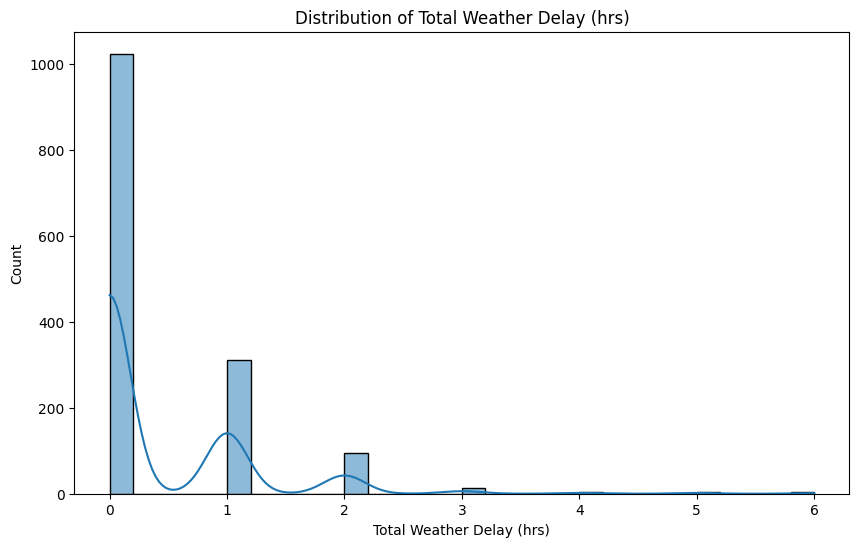

In [ ]:
# --- Looking at distribution of target variable ---
print("Analyzing target variable distribution...")
target_distribution = model_data[TARGET_COLUMN].describe()
print(target_distribution)
plt.figure(figsize=(10, 6))
sns.histplot(model_data[TARGET_COLUMN], bins=30, kde=True)
plt.title('Distribution of Total Weather Delay (hrs)')
plt.xlabel('Total Weather Delay (hrs)')

## Preprocessing

In [22]:
# --- Data Cleaning ---
print("Cleaning data...")
# Drop rows where weather features couldn't be calculated (e.g., arrivals too close to end of weather data)
initial_rows = len(model_data)
model_data.dropna(subset=weather_feature_list.columns, inplace=True) # Drop rows missing weather features
model_data.dropna(subset=[TARGET_COLUMN], inplace=True) # Ensure target is not NaN
# Impute NaNs in STD columns (if window had only 1 data point, std is NaN) - use 0
std_cols = [col for col in weather_feature_list.columns if '_std_' in col]
model_data[std_cols] = model_data[std_cols].fillna(0)

# Optional: Check for other NaNs and decide on imputation strategy if needed
# print(model_data.isnull().sum())

final_rows = len(model_data)
print(f"Dropped {initial_rows - final_rows} rows due to missing features/target.")
if final_rows == 0:
    print("Error: No data remaining after cleaning. Check weather data coverage and feature extraction.")
    exit()

Cleaning data...
Dropped 0 rows due to missing features/target.


In [23]:
# --- Define Features (X) and Target (y) ---
categorical_features = ['type', 'arrival_hour', 'arrival_dayofweek', 'arrival_month']
# Ensure all numerical features are included
numerical_features = ['teu'] + list(weather_feature_list.columns)

# Remove constant columns if any (e.g., if a state never occurred)
for col in numerical_features[:]: # Iterate over a copy
    if col in model_data.columns and model_data[col].nunique() <= 1:
        print(f"Warning: Removing constant or near-constant feature: {col}")
        numerical_features.remove(col)


X = model_data[categorical_features + numerical_features]
y = model_data[TARGET_COLUMN]

print(f"Features selected: {list(X.columns)}")
print(f"Target selected: {TARGET_COLUMN}")

Features selected: ['type', 'arrival_hour', 'arrival_dayofweek', 'arrival_month', 'teu', 'wind_speed_knots_mean_6h', 'wind_speed_knots_max_6h', 'wind_speed_knots_min_6h', 'wind_speed_knots_std_6h', 'visibility_nm_mean_6h', 'visibility_nm_max_6h', 'visibility_nm_min_6h', 'visibility_nm_std_6h', 'wave_height_m_mean_6h', 'wave_height_m_max_6h', 'wave_height_m_min_6h', 'wave_height_m_std_6h', 'wind_speed_knots_mean_12h', 'wind_speed_knots_max_12h', 'wind_speed_knots_min_12h', 'wind_speed_knots_std_12h', 'visibility_nm_mean_12h', 'visibility_nm_max_12h', 'visibility_nm_min_12h', 'visibility_nm_std_12h', 'wave_height_m_mean_12h', 'wave_height_m_max_12h', 'wave_height_m_min_12h', 'wave_height_m_std_12h', 'wind_speed_knots_mean_24h', 'wind_speed_knots_max_24h', 'wind_speed_knots_min_24h', 'wind_speed_knots_std_24h', 'visibility_nm_mean_24h', 'visibility_nm_max_24h', 'visibility_nm_min_24h', 'visibility_nm_std_24h', 'wave_height_m_mean_24h', 'wave_height_m_max_24h', 'wave_height_m_min_24h', 'wa

In [24]:
# --- Train-Test Split ---
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Splitting data into training and testing sets...
Training set size: 1162, Test set size: 291


In [ ]:
# --- Preprocessing Pipeline ---
print("Setting up preprocessing pipeline...")
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) # handle_unknown='ignore' is important


Setting up preprocessing pipeline...


## Setup

In [26]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# --- Define Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), # n_jobs=-1 uses all cores
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror') # Use squared error objective
}

## Training and Evaluation

### Functions

In [54]:
def save_model(pipeline, model_name):
    """
    Save the trained model to a file.
    """
    os.makedirs('models', exist_ok=True) # Ensure the directory exists
    model_filename = f"models/{model_name.replace(' ', '_').lower()}_pipeline.joblib"
    try:
        joblib.dump(pipeline, model_filename)
        print(f"Successfully saved trained pipeline for {model_name} to {model_filename}")
    except Exception as e:
        print(f"Error saving pipeline for {model_name}: {e}")

In [55]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a given model.
    """
    start_train_time = time.time()
    print(f"\n--- Training {model_name} ---")

    # Create full pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Train
    pipeline.fit(X_train, y_train)

    # Save the trained model    
    save_model(pipeline, model_name) 

    # Predict
    y_pred = pipeline.predict(X_test)

    # Ensure predictions are non-negative (delay cannot be negative)
    # y_pred = np.maximum(0, y_pred)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    end_train_time = time.time()
    duration = end_train_time - start_train_time

    results = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Training Time (s)': duration}
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Training/Evaluation Time: {duration:.2f} seconds")

    return pipeline, results

### Running

In [56]:
# --- Train, Predict, and Evaluate Models ---
results = {}
trained_pipelines = {}

print("Training and evaluating models...")
for name, model in models.items():
    trained_pipelines[name], results[name] = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test)


Training and evaluating models...

--- Training Linear Regression ---
Successfully saved trained pipeline for Linear Regression to models/linear_regression_pipeline.joblib
RMSE: 0.7325
MAE: 0.4624
R2 Score: 0.2490
Training/Evaluation Time: 0.08 seconds

--- Training Random Forest ---
Successfully saved trained pipeline for Random Forest to models/random_forest_pipeline.joblib
RMSE: 0.6049
MAE: 0.2863
R2 Score: 0.4879
Training/Evaluation Time: 0.67 seconds

--- Training XGBoost ---
Successfully saved trained pipeline for XGBoost to models/xgboost_pipeline.joblib
RMSE: 0.5568
MAE: 0.2587
R2 Score: 0.5661
Training/Evaluation Time: 0.35 seconds


### Comparison


--- Model Comparison ---
                       RMSE       MAE        R2  Training Time (s)
XGBoost            0.556798  0.258659  0.566107           0.345348
Random Forest      0.604929  0.286254  0.487850           0.667788
Linear Regression  0.732542  0.462375  0.248979           0.083529

--- Feature Importances for Random Forest ---
Saved feature importance plot to Random Forest_feature_importance.png

--- Feature Importances for XGBoost ---
Saved feature importance plot to XGBoost_feature_importance.png


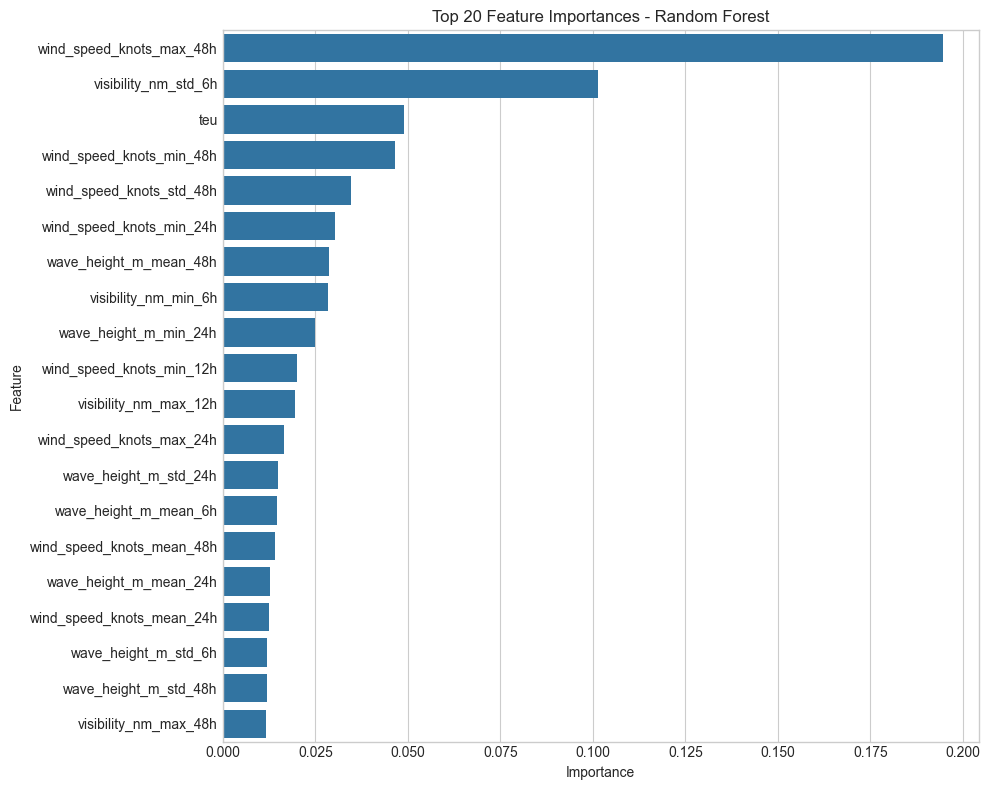

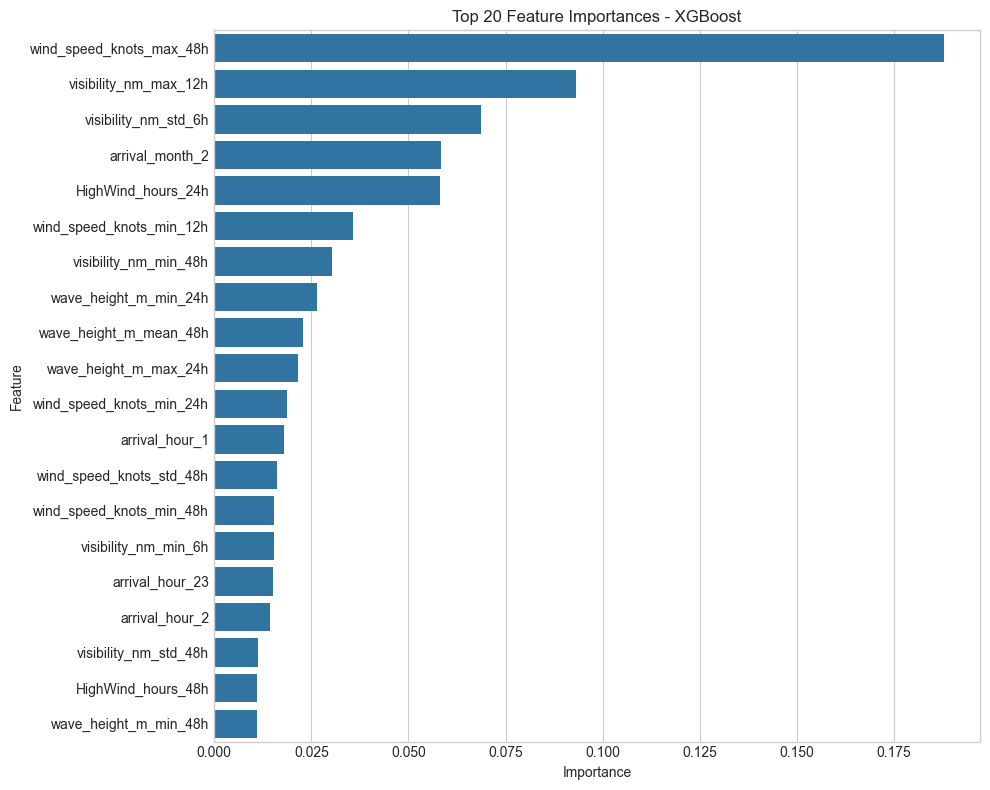

In [57]:
# --- Compare Models ---
print("\n--- Model Comparison ---")
results_df = pd.DataFrame(results).T # Transpose for better readability
results_df = results_df.sort_values(by='RMSE', ascending=True) # Sort by RMSE (lower is better)
print(results_df)

# --- Optional: Feature Importance (for tree-based models) ---
for name in ["Random Forest", "XGBoost"]:
    if name in trained_pipelines:
        print(f"\n--- Feature Importances for {name} ---")
        try:
            # Need to get feature names after one-hot encoding
            feature_names_raw = numerical_features + \
                list(trained_pipelines[name].named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features))

            importances = trained_pipelines[name].named_steps['regressor'].feature_importances_

            # Handle cases where number of features doesn't match importances length
            if len(feature_names_raw) != len(importances):
                 print(f"Warning: Mismatch between feature names ({len(feature_names_raw)}) and importances ({len(importances)}) for {name}. Skipping plot.")
                 continue


            feature_importance_df = pd.DataFrame({'Feature': feature_names_raw, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20) # Show top 20

            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title(f'Top 20 Feature Importances - {name}')
            plt.tight_layout()
            plt.savefig(f"{name}_feature_importance.png") # Save the plot
            print(f"Saved feature importance plot to {name}_feature_importance.png")
            # plt.show() # Uncomment to display plots directly

        except AttributeError:
            print(f"Could not retrieve feature importances for {name}.")
        except Exception as e:
            print(f"An error occurred during feature importance plotting for {name}: {e}")


### Error Analysis

In [63]:
def analyze_model_errors(model_name, pipeline, X_test, y_test):
    """
    Performs error analysis on a trained regression pipeline.

    Args:
        pipeline: Fitted scikit-learn pipeline object.
        X_test: Original test features DataFrame (unprocessed).
        y_test: True target values for the test set.
        model_name (str): Name of the model for plot titles.
    """
    print(f"\n--- Error Analysis for {model_name} ---")

    # 1. Get Predictions
    y_pred = pipeline.predict(X_test)
    # y_pred = np.maximum(0, y_pred) # Ensure non-negative delays

    # 2. Calculate Errors (Residuals)
    residuals = y_test - y_pred

    # --- Visualizations ---
    plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Error Analysis: {model_name}', fontsize=16, y=1.02) # Adjust title position

    # 3. Predicted vs. Actual
    ax = axes[0, 0]
    max_val = max(y_test.max(), y_pred.max()) * 1.1
    min_val = min(y_test.min(), y_pred.min()) * 0.9 if min(y_test.min(), y_pred.min()) < 0 else 0 # Handle potential negative preds before clipping
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.6)
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)') # Ideal line
    ax.set_xlabel("Actual Delay (hours)")
    ax.set_ylabel("Predicted Delay (hours)")
    ax.set_title("Predicted vs. Actual Values")
    ax.set_xlim(left=min_val, right=max_val)
    ax.set_ylim(bottom=min_val, top=max_val)
    ax.legend()
    ax.grid(True)


    # 4. Residual Distribution
    ax = axes[0, 1]
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_xlabel("Residual (Actual - Predicted)")
    ax.set_ylabel("Frequency")
    ax.set_title("Residual Distribution")
    ax.axvline(0, color='r', linestyle='--') # Line at zero error
    ax.grid(True)


    # 5. Residuals vs. Predicted
    ax = axes[1, 0]
    sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.6)
    ax.axhline(0, color='r', linestyle='--', lw=2) # Line at zero error
    ax.set_xlabel("Predicted Delay (hours)")
    ax.set_ylabel("Residual (Actual - Predicted)")
    ax.set_title("Residuals vs. Predicted Values")
    ax.grid(True)

    # 6. Residuals vs. a Key Feature (Example: 'teu')
    ax = axes[1, 1]
    key_feature = 'teu' # Choose an important feature to plot against
    if key_feature in X_test.columns:
         sns.scatterplot(x=X_test[key_feature], y=residuals, ax=ax, alpha=0.6)
         ax.axhline(0, color='r', linestyle='--', lw=2)
         ax.set_xlabel(f"Feature: {key_feature}")
         ax.set_ylabel("Residual (Actual - Predicted)")
         ax.set_title(f"Residuals vs. {key_feature}")
         ax.grid(True)
    else:
         ax.text(0.5, 0.5, f"Feature '{key_feature}' not found in X_test.", ha='center', va='center')
         ax.set_title(f"Residuals vs. {key_feature} (Not Found)")


    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.98)) # Adjust layout to prevent title overlap
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_error_analysis.png")
    print(f"Saved error analysis plot to {model_name.replace(' ', '_').lower()}_error_analysis.png")
    # plt.show() # Uncomment to display plots

    # 7. (Optional) Identify Largest Errors
    error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
    error_df['Abs_Residual'] = error_df['Residual'].abs()
    largest_errors = error_df.sort_values(by='Abs_Residual', ascending=False).head(10)

    print("\nTop 10 Largest Absolute Errors:")
    print(largest_errors)

    # You could join this back with X_test on index to see the features for the worst predictions
    # print(X_test.loc[largest_errors.index])

#### XGBoost


--- Error Analysis for XGBoost ---
Saved error analysis plot to xgboost_error_analysis.png

Top 10 Largest Absolute Errors:
      Actual  Predicted  Residual  Abs_Residual
1073     6.0   1.518597  4.481403      4.481403
1030     6.0   1.850699  4.149301      4.149301
271      2.0   0.100987  1.899013      1.899013
123      0.0   1.850534 -1.850534      1.850534
1246     3.0   1.177951  1.822049      1.822049
1391     2.0   0.210606  1.789394      1.789394
705      0.0   1.537233 -1.537233      1.537233
1338     2.0   0.499399  1.500601      1.500601
755      0.0   1.489323 -1.489323      1.489323
787      0.0   1.445005 -1.445005      1.445005


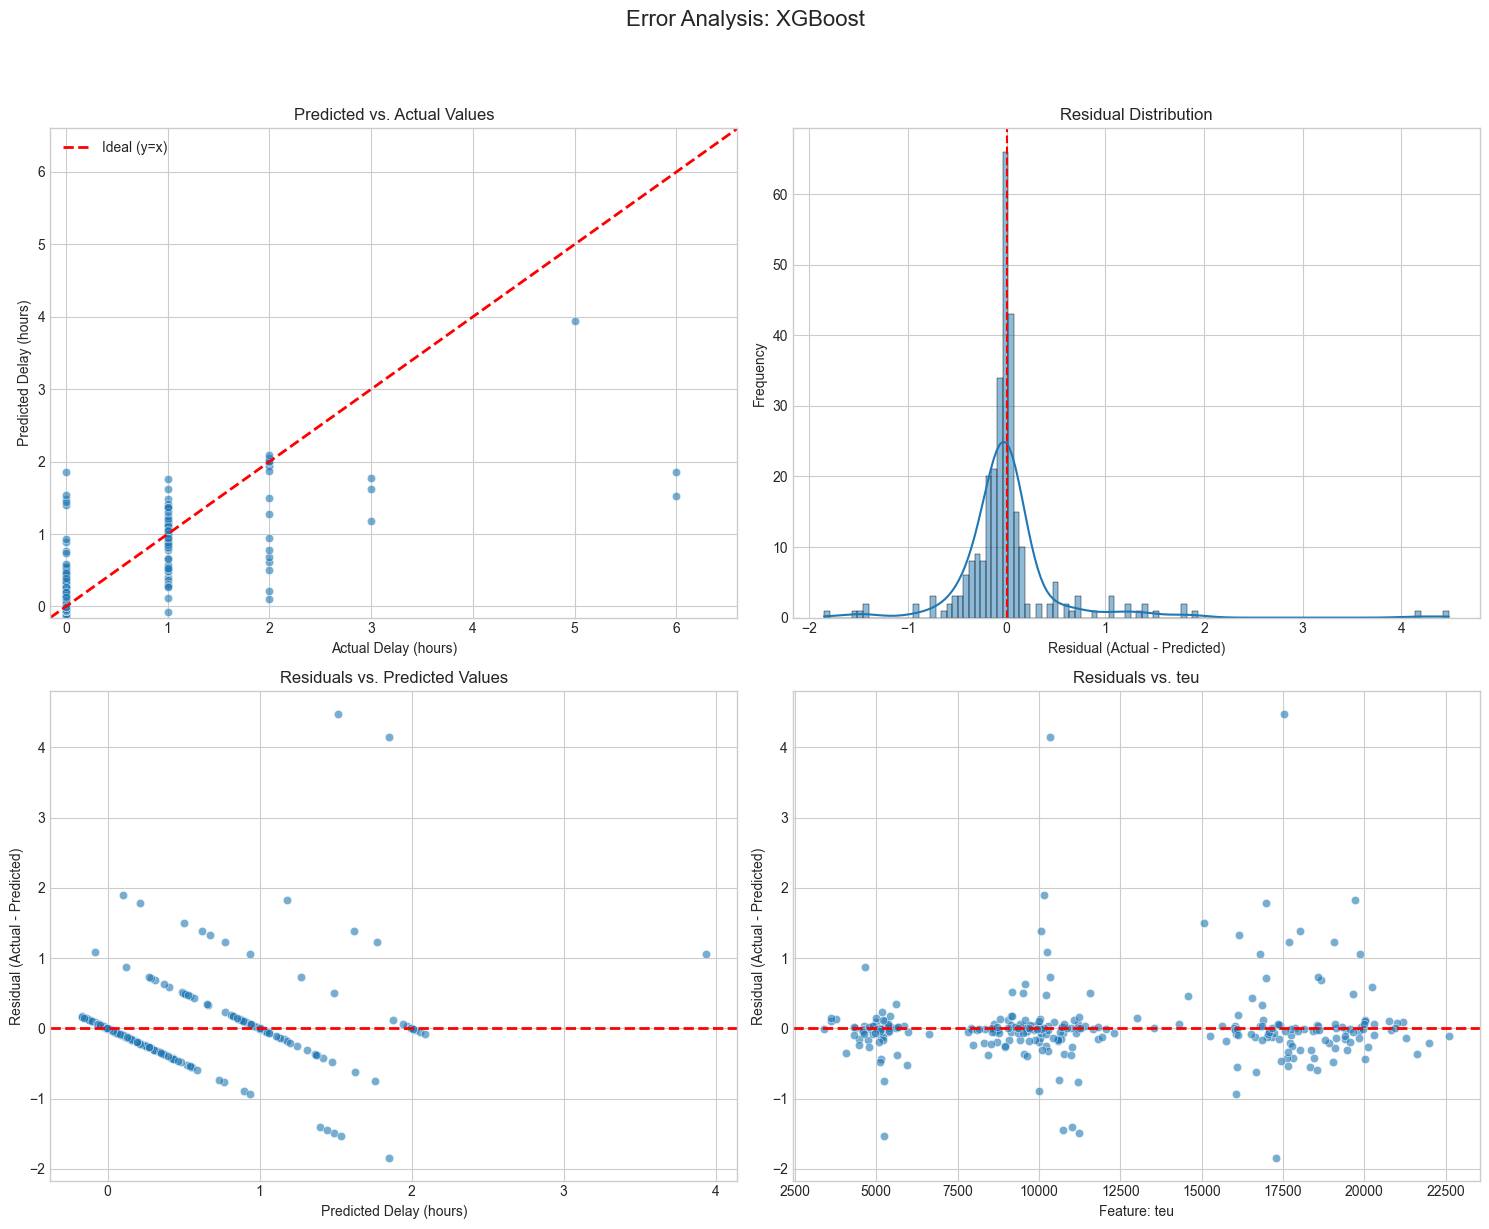

In [64]:
analyze_model_errors("XGBoost", trained_pipelines["XGBoost"], X_test, y_test)
